Model based on paper:

Özer, İlyas, Serhat Berat Efe, and Harun Özbay. "CNN/Bi‐LSTM‐based deep learning algorithm for classification of power quality disturbances by using spectrogram images." International Transactions on Electrical Energy Systems 31.12 (2021): e13204.


Testing and training datasets by Kramer et al. (2022)

[link to paper](10.3389/fdgth.2022.847555)

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models

from keras.layers import GaussianNoise
from IPython import display

from parameters_kramer import parameters

# Set the seed value for experiment reproducibility.
seed = 2
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
!python --version 

print('Tensorflow version', tf.__version__)

Python 3.8.11
Tensorflow version 2.9.1


In [3]:
parameters = parameters()
data_length = parameters['data_length']

### Import dataset

In [4]:
dataset_path = parameters['train_data']
# model_save_path = parameters['path_model']
data_dir = pathlib.Path(dataset_path)

The dataset WAV files are stored in two folders: `0` and `1`

In [5]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['0' '1']


Extract the ECGs into a list called `filenames`, and shuffle it:

In [6]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total samples:', num_samples)
print('Number of samples per label:', len(tf.io.gfile.listdir(str(data_dir/commands[0]))), len(tf.io.gfile.listdir(str(data_dir/commands[1]))))
# print('Example file tensor:', filenames[0])

Number of total samples: 1200
Number of samples per label: 385 815


Split `filenames` into training, validation and test sets using a 80:10:10 ratio, respectively:


In [7]:
nr_train = int(num_samples * 0.9)
nr_val = int(num_samples / 10)

train_files = filenames[:nr_train]
val_files = filenames[nr_train: nr_train + nr_val]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))

Training set size 1080
Validation set size 120


## Read the ecg files and their labels

In this section you will preprocess the dataset, creating decoded tensors for the waveforms and the corresponding labels. Note that:

- Each WAV file contains time-series data with a set number of samples per second.
- Each sample represents the <a href="https://en.wikipedia.org/wiki/Amplitude" class="external">amplitude</a> of the ECG signal at that specific time.
- In a <a href="https://en.wikipedia.org/wiki/Audio_bit_depth" class="external">16-bit</a> system, like WAV files, the amplitude values range from -32,768 to 32,767.
- The <a href="https://en.wikipedia.org/wiki/Sampling_(signal_processing)#Audio_sampling" class="external">sample rate</a> for the ECG data used is 500 Hz

The shape of the tensor returned by `tf.audio.decode_wav` is `[samples, channels]`, which is `[5000, 1]` for 500 Hz 10 second data. 

In [8]:
# test_file = tf.io.read_file(dataset_path+'/1/A00001.wav')
# test_ecg, _ = tf.audio.decode_wav(contents=test_file)
# test_ecg.shape

Now, let's define a function that preprocesses the dataset's raw WAV ECG files into audio tensors:

In [9]:
def decode_wav_file(ecg_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
    ecg, _ = tf.audio.decode_wav(contents=ecg_binary)
    return tf.squeeze(ecg, axis=-1)


Define a function that creates labels using the parent directories for each file:

- Split the file paths into `tf.RaggedTensor`s (tensors with ragged dimensions—with slices that may have different lengths).

In [10]:
def get_label(file_path):
    parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
    # Note: You'll use indexing here instead of tuple unpacking to enable this
    # to work in a TensorFlow graph.
    return parts[-2]

Define another helper function—`get_waveform_and_label`—that puts it all together:

- The input is the WAV ECG filename.
- The output is a tuple containing the ECG and label tensors ready for supervised learning.

In [11]:
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    ecg_binary = tf.io.read_file(file_path)
    waveform = decode_wav_file(ecg_binary)
    return waveform, label

Build the training set to extract the ECG-label pairs:

- Create a `tf.data.Dataset` with `Dataset.from_tensor_slices` and `Dataset.map`, using `get_waveform_and_label` defined earlier.

You'll build the validation and test sets using a similar procedure later on.

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

Let's plot a few ECG waveforms:

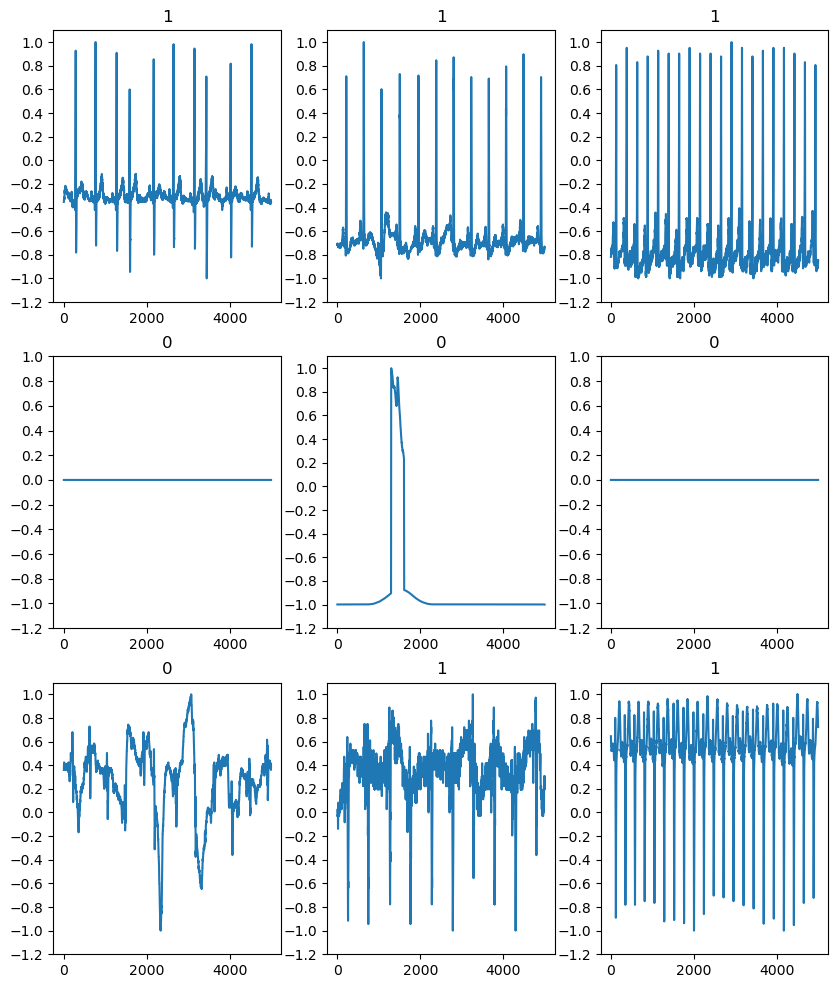

In [13]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (ecg, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(ecg.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)

plt.show()

## Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the <a href="https://en.wikipedia.org/wiki/Short-time_Fourier_transform" class="external">short-time Fourier transform (STFT)</a> to convert the waveforms to as <a href="https://en.wikipedia.org/wiki/Spectrogram" clas="external">spectrograms</a>, which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. 
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [14]:
def get_spectrogram(waveform):
    # cropping for waveform smaller than the desired 5000 (not the case for this data)
#     waveform = waveform[:5000]

    # Cast the waveform tensors' dtype to float32.
    waveform = tf.cast(waveform, dtype=tf.float32)
    
    # In case the data is different length (not the case for this data)
#     zero_padding = tf.zeros(
#       [input_len] - tf.shape(waveform),
#       dtype=tf.float32)
#     equal_length = tf.concat([waveform, zero_padding], 0) 

    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram

In [15]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy()
    spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)

Label: b'1'
Waveform shape: (5000,)
Spectrogram shape: (38, 129, 1)


Defining a function for displaying a spectrogram:

In [16]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
        # Convert the frequencies to log scale and transpose, so that the time is
        # represented on the x-axis (columns).
        # Add an epsilon to avoid taking a log of zero.
        log_spec = np.log(spectrogram.T + np.finfo(float).eps)
        height = log_spec.shape[0]
        width = log_spec.shape[1]
        X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
        Y = range(height)
        ax.pcolormesh(X, Y, log_spec, shading='auto')

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

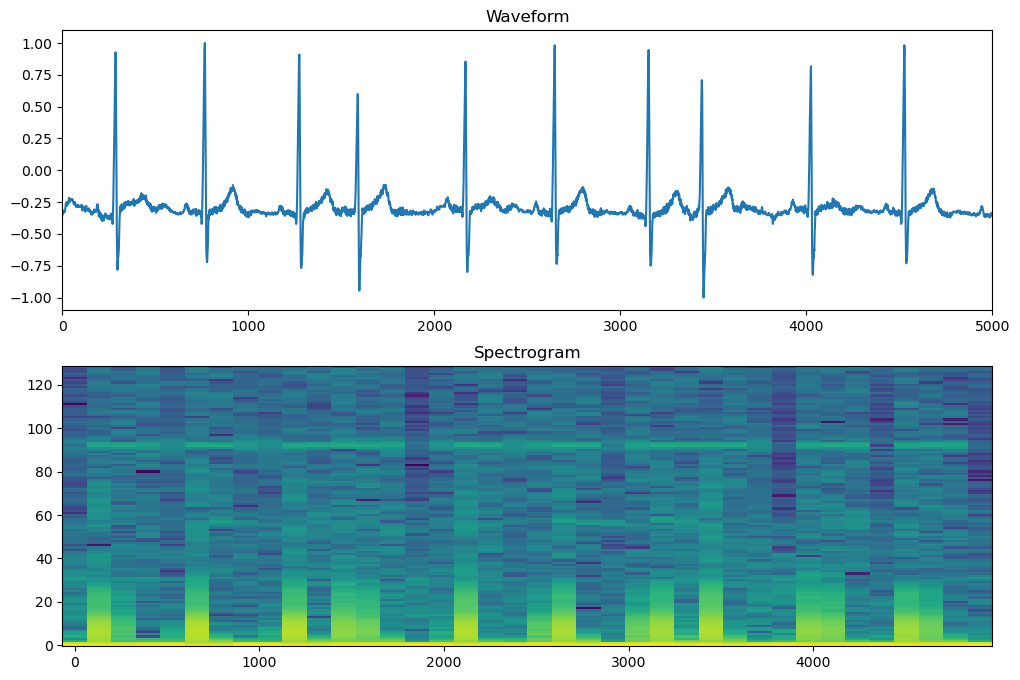

In [17]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, data_length])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()



Now, define a function that transforms the waveform dataset into spectrograms and their corresponding labels as integer IDs:

In [18]:
def get_spectrogram_and_label_id(ecg, label):
    spectrogram = get_spectrogram(ecg)
    label_id = tf.math.argmax(label == commands)
    return spectrogram, label_id

Map `get_spectrogram_and_label_id` across the dataset's elements with `Dataset.map`:

In [19]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

Examine the spectrograms for different examples of the dataset:

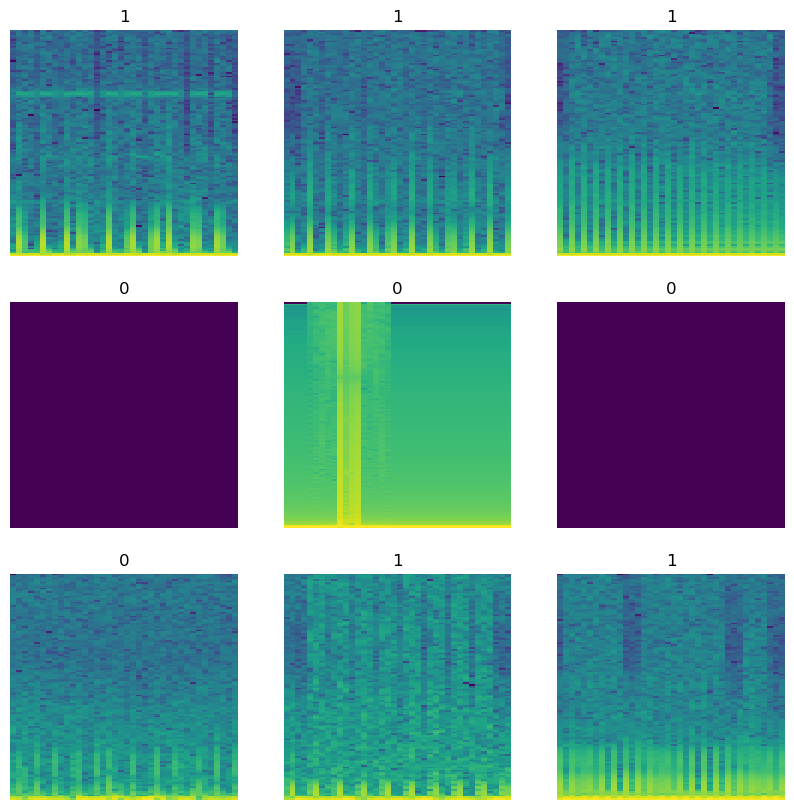

In [20]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(spectrogram.numpy(), ax)
    ax.set_title(commands[label_id.numpy()])
    ax.axis('off')

plt.show()

## Build and train the model

Repeat the training set preprocessing on the validation and test sets:

In [21]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
    return output_ds

In [22]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)

Batch the training and validation sets for model training:

In [23]:
batch_size = 32
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [24]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

`tf.keras.Sequential` model uses the following Keras preprocessing layers:

- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).


# CNN/Bi-LSTM model

The CNN part of the algorithm consists of three blocks that downsample the data through convolutions. Each block consists of a CNN layer, a max pooling layer, and a dropout layer. 

In [25]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))


model = models.Sequential([
    layers.Input(shape=(input_shape[0],input_shape[1])),
    norm_layer,
    layers.Conv1D(32, 3, activation='relu'),
    layers.MaxPooling1D(),
    layers.Dropout(0.2),
    layers.Conv1D(32, 3, activation='relu'),
    layers.MaxPooling1D(),
    layers.Dropout(0.2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(),
    layers.Dropout(0.2),
    layers.Dense(100), 
    layers.LSTM(100),
    layers.Dropout(0.2),
    layers.Dense(29),
    layers.Dense(num_labels, activation='sigmoid'),
])

model.summary()


Input shape: (38, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 38, 129)          3         
 n)                                                              
                                                                 
 conv1d (Conv1D)             (None, 36, 32)            12416     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 18, 32)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 18, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPooling  

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [26]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

Train the model over 500 epochs:

In [27]:
EPOCHS = 500
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
#     callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=10),
)


Epoch 1/500
34/34 [==============================] - 4s 40ms/step - loss: 0.5802 - accuracy: 0.7019 - val_loss: 0.5801 - val_accuracy: 0.8583
Epoch 2/500
34/34 [==============================] - 0s 12ms/step - loss: 0.5234 - accuracy: 0.7111 - val_loss: 0.5516 - val_accuracy: 0.8583
Epoch 3/500
34/34 [==============================] - 0s 14ms/step - loss: 0.5004 - accuracy: 0.7167 - val_loss: 0.5397 - val_accuracy: 0.8583
Epoch 4/500
34/34 [==============================] - 1s 15ms/step - loss: 0.4822 - accuracy: 0.7194 - val_loss: 0.5347 - val_accuracy: 0.8583
Epoch 5/500
34/34 [==============================] - 1s 16ms/step - loss: 0.4730 - accuracy: 0.7343 - val_loss: 0.5324 - val_accuracy: 0.8583
Epoch 6/500
34/34 [==============================] - 1s 15ms/step - loss: 0.4713 - accuracy: 0.7704 - val_loss: 0.5306 - val_accuracy: 0.8583
Epoch 7/500
34/34 [==============================] - 1s 16ms/step - loss: 0.4643 - accuracy: 0.8083 - val_loss: 0.5287 - val_accuracy: 0.8583
Epoch 

34/34 [==============================] - 0s 14ms/step - loss: 0.1837 - accuracy: 0.9250 - val_loss: 0.3143 - val_accuracy: 0.8583
Epoch 59/500
34/34 [==============================] - 0s 14ms/step - loss: 0.1631 - accuracy: 0.9444 - val_loss: 0.3229 - val_accuracy: 0.8583
Epoch 60/500
34/34 [==============================] - 0s 14ms/step - loss: 0.1694 - accuracy: 0.9389 - val_loss: 0.3140 - val_accuracy: 0.8583
Epoch 61/500
34/34 [==============================] - 0s 14ms/step - loss: 0.1624 - accuracy: 0.9472 - val_loss: 0.3122 - val_accuracy: 0.8583
Epoch 62/500
34/34 [==============================] - 0s 15ms/step - loss: 0.1660 - accuracy: 0.9426 - val_loss: 0.3152 - val_accuracy: 0.8583
Epoch 63/500
34/34 [==============================] - 1s 15ms/step - loss: 0.1694 - accuracy: 0.9352 - val_loss: 0.3041 - val_accuracy: 0.8583
Epoch 64/500
34/34 [==============================] - 0s 14ms/step - loss: 0.1555 - accuracy: 0.9454 - val_loss: 0.3057 - val_accuracy: 0.8583
Epoch 65/500

34/34 [==============================] - 0s 13ms/step - loss: 0.1013 - accuracy: 0.9667 - val_loss: 0.2272 - val_accuracy: 0.9250
Epoch 116/500
34/34 [==============================] - 0s 14ms/step - loss: 0.1093 - accuracy: 0.9574 - val_loss: 0.2248 - val_accuracy: 0.9250
Epoch 117/500
34/34 [==============================] - 0s 14ms/step - loss: 0.1038 - accuracy: 0.9574 - val_loss: 0.2247 - val_accuracy: 0.9250
Epoch 118/500
34/34 [==============================] - 0s 15ms/step - loss: 0.1014 - accuracy: 0.9611 - val_loss: 0.2212 - val_accuracy: 0.9250
Epoch 119/500
34/34 [==============================] - 0s 14ms/step - loss: 0.1022 - accuracy: 0.9583 - val_loss: 0.2255 - val_accuracy: 0.9250
Epoch 120/500
34/34 [==============================] - 0s 14ms/step - loss: 0.1074 - accuracy: 0.9611 - val_loss: 0.2260 - val_accuracy: 0.9250
Epoch 121/500
34/34 [==============================] - 0s 14ms/step - loss: 0.1105 - accuracy: 0.9611 - val_loss: 0.2366 - val_accuracy: 0.9250
Epoch 

Epoch 172/500
34/34 [==============================] - 0s 14ms/step - loss: 0.0887 - accuracy: 0.9657 - val_loss: 0.1836 - val_accuracy: 0.9417
Epoch 173/500
34/34 [==============================] - 0s 14ms/step - loss: 0.0979 - accuracy: 0.9676 - val_loss: 0.1874 - val_accuracy: 0.9417
Epoch 174/500
34/34 [==============================] - 0s 14ms/step - loss: 0.0879 - accuracy: 0.9639 - val_loss: 0.1849 - val_accuracy: 0.9417
Epoch 175/500
34/34 [==============================] - 0s 15ms/step - loss: 0.0850 - accuracy: 0.9694 - val_loss: 0.1859 - val_accuracy: 0.9417
Epoch 176/500
34/34 [==============================] - 0s 14ms/step - loss: 0.0812 - accuracy: 0.9685 - val_loss: 0.1866 - val_accuracy: 0.9417
Epoch 177/500
34/34 [==============================] - 1s 15ms/step - loss: 0.0821 - accuracy: 0.9685 - val_loss: 0.1884 - val_accuracy: 0.9417
Epoch 178/500
34/34 [==============================] - 1s 15ms/step - loss: 0.0872 - accuracy: 0.9704 - val_loss: 0.1806 - val_accuracy:

Epoch 229/500
34/34 [==============================] - 0s 14ms/step - loss: 0.0786 - accuracy: 0.9731 - val_loss: 0.1534 - val_accuracy: 0.9500
Epoch 230/500
34/34 [==============================] - 1s 15ms/step - loss: 0.0853 - accuracy: 0.9694 - val_loss: 0.1539 - val_accuracy: 0.9500
Epoch 231/500
34/34 [==============================] - 1s 15ms/step - loss: 0.0799 - accuracy: 0.9676 - val_loss: 0.1524 - val_accuracy: 0.9500
Epoch 232/500
34/34 [==============================] - 0s 15ms/step - loss: 0.0710 - accuracy: 0.9704 - val_loss: 0.1532 - val_accuracy: 0.9500
Epoch 233/500
34/34 [==============================] - 0s 15ms/step - loss: 0.0736 - accuracy: 0.9704 - val_loss: 0.1522 - val_accuracy: 0.9500
Epoch 234/500
34/34 [==============================] - 1s 15ms/step - loss: 0.0733 - accuracy: 0.9676 - val_loss: 0.1587 - val_accuracy: 0.9417
Epoch 235/500
34/34 [==============================] - 0s 14ms/step - loss: 0.0841 - accuracy: 0.9713 - val_loss: 0.1535 - val_accuracy:

Epoch 286/500
34/34 [==============================] - 1s 15ms/step - loss: 0.0790 - accuracy: 0.9704 - val_loss: 0.1407 - val_accuracy: 0.9583
Epoch 287/500
34/34 [==============================] - 0s 14ms/step - loss: 0.0684 - accuracy: 0.9722 - val_loss: 0.1420 - val_accuracy: 0.9583
Epoch 288/500
34/34 [==============================] - 0s 14ms/step - loss: 0.0628 - accuracy: 0.9704 - val_loss: 0.1397 - val_accuracy: 0.9583
Epoch 289/500
34/34 [==============================] - 0s 15ms/step - loss: 0.0680 - accuracy: 0.9750 - val_loss: 0.1405 - val_accuracy: 0.9583
Epoch 290/500
34/34 [==============================] - 0s 15ms/step - loss: 0.0732 - accuracy: 0.9731 - val_loss: 0.1425 - val_accuracy: 0.9583
Epoch 291/500
34/34 [==============================] - 0s 14ms/step - loss: 0.0696 - accuracy: 0.9731 - val_loss: 0.1405 - val_accuracy: 0.9583
Epoch 292/500
34/34 [==============================] - 0s 14ms/step - loss: 0.0752 - accuracy: 0.9713 - val_loss: 0.1365 - val_accuracy:

Epoch 343/500
34/34 [==============================] - 0s 14ms/step - loss: 0.0582 - accuracy: 0.9769 - val_loss: 0.1349 - val_accuracy: 0.9583
Epoch 344/500
34/34 [==============================] - 1s 15ms/step - loss: 0.0643 - accuracy: 0.9769 - val_loss: 0.1321 - val_accuracy: 0.9583
Epoch 345/500
34/34 [==============================] - 0s 15ms/step - loss: 0.0679 - accuracy: 0.9731 - val_loss: 0.1332 - val_accuracy: 0.9583
Epoch 346/500
34/34 [==============================] - 1s 15ms/step - loss: 0.0609 - accuracy: 0.9778 - val_loss: 0.1278 - val_accuracy: 0.9583
Epoch 347/500
34/34 [==============================] - 1s 15ms/step - loss: 0.0531 - accuracy: 0.9759 - val_loss: 0.1329 - val_accuracy: 0.9583
Epoch 348/500
34/34 [==============================] - 0s 15ms/step - loss: 0.0643 - accuracy: 0.9778 - val_loss: 0.1344 - val_accuracy: 0.9583
Epoch 349/500
34/34 [==============================] - 1s 15ms/step - loss: 0.0593 - accuracy: 0.9787 - val_loss: 0.1312 - val_accuracy:

Epoch 400/500
34/34 [==============================] - 0s 15ms/step - loss: 0.0621 - accuracy: 0.9769 - val_loss: 0.1202 - val_accuracy: 0.9583
Epoch 401/500
34/34 [==============================] - 0s 14ms/step - loss: 0.0541 - accuracy: 0.9778 - val_loss: 0.1254 - val_accuracy: 0.9583
Epoch 402/500
34/34 [==============================] - 0s 15ms/step - loss: 0.0571 - accuracy: 0.9778 - val_loss: 0.1240 - val_accuracy: 0.9583
Epoch 403/500
34/34 [==============================] - 0s 14ms/step - loss: 0.0582 - accuracy: 0.9759 - val_loss: 0.1279 - val_accuracy: 0.9583
Epoch 404/500
34/34 [==============================] - 0s 14ms/step - loss: 0.0611 - accuracy: 0.9759 - val_loss: 0.1295 - val_accuracy: 0.9583
Epoch 405/500
34/34 [==============================] - 1s 16ms/step - loss: 0.0543 - accuracy: 0.9787 - val_loss: 0.1320 - val_accuracy: 0.9583
Epoch 406/500
34/34 [==============================] - 1s 15ms/step - loss: 0.0542 - accuracy: 0.9815 - val_loss: 0.1311 - val_accuracy:

Epoch 457/500
34/34 [==============================] - 0s 14ms/step - loss: 0.0532 - accuracy: 0.9787 - val_loss: 0.1253 - val_accuracy: 0.9583
Epoch 458/500
34/34 [==============================] - 1s 15ms/step - loss: 0.0505 - accuracy: 0.9778 - val_loss: 0.1221 - val_accuracy: 0.9583
Epoch 459/500
34/34 [==============================] - 1s 15ms/step - loss: 0.0535 - accuracy: 0.9778 - val_loss: 0.1253 - val_accuracy: 0.9583
Epoch 460/500
34/34 [==============================] - 1s 15ms/step - loss: 0.0526 - accuracy: 0.9806 - val_loss: 0.1254 - val_accuracy: 0.9583
Epoch 461/500
34/34 [==============================] - 1s 15ms/step - loss: 0.0499 - accuracy: 0.9806 - val_loss: 0.1207 - val_accuracy: 0.9583
Epoch 462/500
34/34 [==============================] - 1s 15ms/step - loss: 0.0542 - accuracy: 0.9796 - val_loss: 0.1212 - val_accuracy: 0.9583
Epoch 463/500
34/34 [==============================] - 0s 14ms/step - loss: 0.0456 - accuracy: 0.9815 - val_loss: 0.1163 - val_accuracy:

Let's plot the training and validation loss curves to check how the model has improved during training:

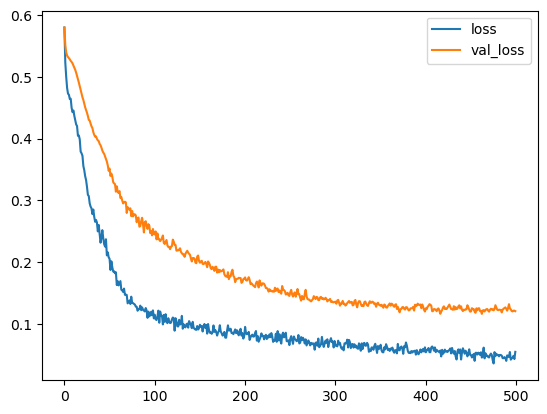

In [28]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

Save the model for later usage:

In [29]:
# model.save(model_save_path+'/'+parameters['model_name'])

Load previously trained model:

In [30]:
# model = tf.keras.models.load_model(model_save_path+'/'+parameters['model_name'])

## Evaluate the model performance

Run the model on the test set and check the model's performance:

# Test Kramer testing data

In [31]:
test_path = parameters['test_data']
test_dir = pathlib.Path(test_path)
test_filenames = tf.io.gfile.glob(str(test_dir) + '/*/*')
test_filenames = tf.random.shuffle(test_filenames)
num_samples = len(test_filenames)
print('Number of total samples:', num_samples)
print('Number of samples per label:', len(tf.io.gfile.listdir(str(test_dir/commands[0]))))
# print('Example file tensor:', test_filenames[0])

Number of total samples: 4200
Number of samples per label: 1356


Preprocess the data:

In [32]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
    return output_ds

Display the spectrograms of the created dataset:

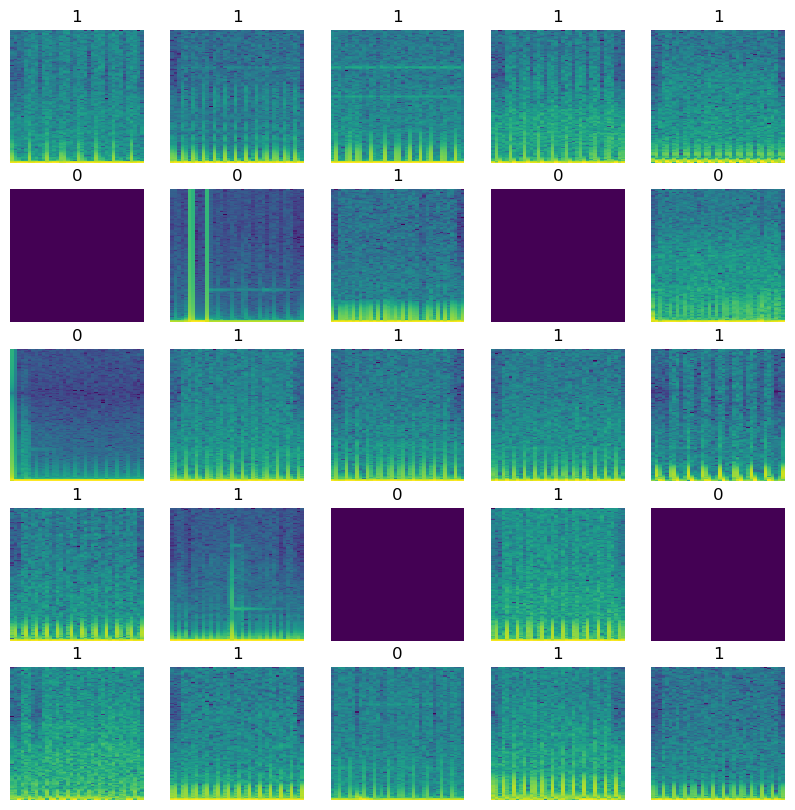

In [33]:
test_kramer = preprocess_dataset(test_filenames)

rows = 5
cols = 5
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(test_kramer.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(spectrogram.numpy(), ax)
    ax.set_title(commands[label_id.numpy()])
    ax.axis('off')

plt.show()
test_kramer = test_kramer.cache().prefetch(AUTOTUNE)

In [34]:
def preprocess_dataset_plot(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
    return output_ds

In [35]:
# kramer_plot = preprocess_dataset_plot(val_filenames)
    
# # t_kramer = kramer_plot.take(10)
# # for i in range(10):
# n = 2

# for waveform_kramer, label_kramer in kramer_plot.take(n):    
#     label_kramer = label_kramer.numpy()
#     spectrogram_kramer = get_spectrogram(waveform_kramer)

#     print('Label:', label_kramer)
#     print('Waveform shape:', waveform_kramer.shape)
#     print('Spectrogram shape:', spectrogram_kramer.shape)

#     fig, axes = plt.subplots(2, figsize=(12, 8))
#     timescale = np.arange(waveform_kramer.shape[0])
#     axes[0].plot(timescale, waveform_kramer.numpy())
#     axes[0].set_title('Waveform')
#     axes[0].set_xlim([0, data_length])

#     plot_spectrogram(spectrogram_kramer.numpy(), axes[1])
#     axes[1].set_title('Spectrogram')
#     plt.show()

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [36]:
test_kramer_ecg = []
test_kramer_labels = []

for ecg, label in test_kramer:
    test_kramer_ecg.append(ecg.numpy())
    test_kramer_labels.append(label.numpy())

test_kramer_ecg = np.array(test_kramer_ecg)
test_kramer_labels = np.array(test_kramer_labels)

In [37]:
y_pred_kramer = np.argmax(model.predict(test_kramer_ecg), axis=1)
y_true_kramer = test_kramer_labels

test_acc_kramer = sum(y_pred_kramer == y_true_kramer) / len(y_true_kramer)
print(f'Test set accuracy: {test_acc_kramer}')

132/132 [==============================] - 4s 27ms/step
Test set accuracy: 0.9623809523809523


In [39]:
true_positive_kramer = 0
for i in range(len(y_true_kramer)):
    true_positive_kramer += (y_true_kramer[i] * y_pred_kramer[i])
    
false_negative_kramer = sum(y_true_kramer) - true_positive_kramer

sensitivity_kramer = (true_positive_kramer / (true_positive_kramer + false_negative_kramer)) * 100

print('Sensitivity', sensitivity_kramer)

false_positive_kramer = sum(y_pred_kramer) - true_positive_kramer
true_negative_kramer = len(y_pred_kramer) - true_positive_kramer - false_positive_kramer - false_negative_kramer

specificity_kramer = (true_negative_kramer / (false_positive_kramer + true_negative_kramer)) * 100

print('Specificity', specificity_kramer)

Sensitivity 98.24191279887482
Specificity 92.03539823008849


In [40]:
f1_score_kramer = ((true_positive_kramer)/(true_positive_kramer + 0.5 * (false_positive_kramer + false_negative_kramer)))

print('F1 score', f1_score_kramer)

F1 score 0.9725026105116603


### Display a confusion matrix

Use a <a href="https://developers.google.com/machine-learning/glossary#confusion-matrix" class="external">confusion matrix</a> to check how well the model did classifying each of the commands in the test set:


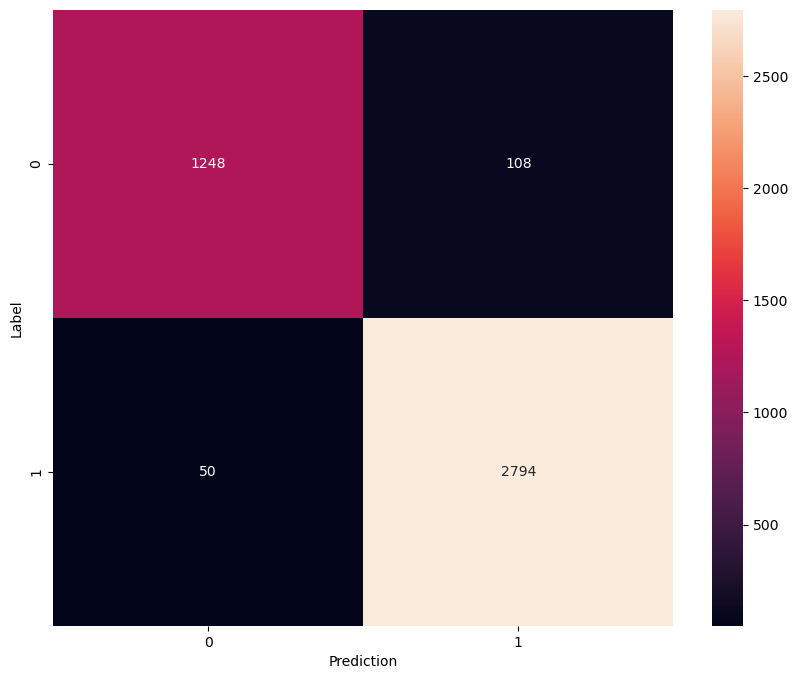

In [41]:
confusion_mtx = tf.math.confusion_matrix(y_true_kramer, y_pred_kramer)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()